In [21]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


# Fix global random seed for reproducibility
SEED = 0

# Data preprocessing

In the following, we show how the data has been preprocessed. We started by downloading 36609 genomes from PubMLST. From this initial set, we selected only non-complete genomes of _Neisseria meningitidis_, narrowing the set to 25959 genomes.

In [22]:
genomes = pd.read_csv("../data/genomes.csv", low_memory=False)
genomes = genomes[(genomes.species=="Neisseria meningitidis") & (genomes.Complete==0)]
print("Total genomes:", genomes.shape[0])

Total genomes: 25959


From the remaining genomes, we build the two datasets used in this study:
- `capsule`, the dataset used to train a classifier to distinguish capsule group-B (`1`) vs. non capsule group-B (`0`) genomes;
- `disease`, the dataset used to train a classifier to distinguish invasive (`1`) from carriage (`0`) genomes.

## `capsule` dataset

We start off by filtering out all the genomes where `capsule_group` is unknown or labelled as `discrepancy`, restricting the set of usable genomes to 25290.

In [23]:
capsule_genomes = genomes[genomes.capsule_group.notnull() & (genomes.capsule_group!="discrepancy")].copy()
print("Total genomes for capsule task:", capsule_genomes.shape[0])

Total genomes for capsule task: 25290


We label each genome with `1` if its `capsule_group` is `B`, and with `0` otherwise. 

In [24]:
def get_capsule_label(capsule_group: str) -> int:
    if capsule_group == "B":
        return 1
    return 0

capsule_genomes["Label"] = capsule_genomes.capsule_group.apply(get_capsule_label)

print("Distribution of labels:")
capsule_genomes.Label.value_counts()

Distribution of labels:


0    15124
1    10166
Name: Label, dtype: int64

For each genome, we calculate the fraction of the genome covered by the 10 longest contigs (in terms of number of bases):

In [25]:
NUM_CONTIGS = 10

def read_fasta(path: str) -> List[SeqRecord]:
    """Loads BioPython SeqRecords given the path to a fasta file."""
    return list(SeqIO.parse(path, "fasta"))


def _calculate_fraction_covered(genome_path: str) -> dict:
    """
    Calculates the fraction of a genome (accessible with `genome_path`)
    covered by the `num` longest contigs.
    """
    contigs = [str(c.seq) for c in read_fasta(genome_path)]
    if len(contigs) <= NUM_CONTIGS:
        return {"Path": genome_path, "FractionCovered": 1.0}

    sorted_lengths = sorted([len(cont) for cont in contigs], reverse=True)
    numerator = sum(sorted_lengths[:NUM_CONTIGS])
    denominator = sum(sorted_lengths)
    return {"Path": genome_path, f"FractionCovered": numerator / denominator}


def calculate_fraction_covered(genomes_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a column to the geneomes in the DataFrame `genomes_file` containing the genome
    fraction covered by the `num` longest contigs.
    """
    results = Parallel(verbose=1, n_jobs=-1)(
        delayed(_calculate_fraction_covered)(p)
        for p in genomes_df.Path.tolist()
    )
    return pd.merge(genomes_df, pd.DataFrame(results), on="Path")

def format_and_save_dataset(df: pd.DataFrame, filename: str):
    columns = ["id", "isolate", "Label", "FractionCovered"]
    df[columns].to_csv(filename, index=False)

updated_capsule_genomes = calculate_fraction_covered(capsule_genomes)
format_and_save_dataset(updated_capsule_genomes, "fig2_panelA.csv")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1924 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 3024 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 4324 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 7524 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 9424 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 11524 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 13824 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 16324 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 19024 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 21924 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 25024 task

If we plot a histogram the `FractionCovered` stratified by `Capsule type`, we find that the 10 longest contigs of genomes labelled with `0` cover in general a larger fraction of the genome than genomes labelled with `1`. To prevent the classifier from picking this pattern to distinguish class `0` from class `1`, we will remove this bias.

(0.0, 705.0)

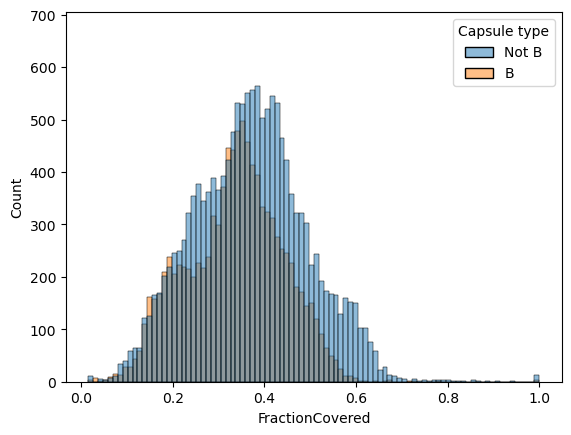

In [26]:
hp_data = updated_capsule_genomes.copy()
hp_data.Label = hp_data.Label.apply(lambda x: "Not B" if x == 0 else "B")
hp_data = hp_data.rename({"Label": "Capsule type"}, axis=1)
ax = sns.histplot(data=hp_data, x="FractionCovered", hue="Capsule type", hue_order=["Not B", "B"])
ax.set_ylim([0, 705])

To remove the bias, we proceed as follows:
- we cluster `FractionCovered` in 512 clusters using `sklearn.cluster.KMeans`
- for each cluster, we downsample the majority class within the cluster so that its amount is equal to the minority class.

In [27]:
NUM_CLUSTERS = 512

def balance_quality(genomes_df: pd.DataFrame) -> pd.DataFrame:
    """Balances dataset quality."""

    X = genomes_df[f"FractionCovered"].values.reshape(-1, 1)  
    genomes_df["Cluster"] = KMeans(
        n_clusters=NUM_CLUSTERS, 
        random_state=SEED,
    ).fit_predict(X)

    def select_genomes(df, cluster, label):
        subset = df[(df.Cluster==cluster) & (df.Label==label)]
        return subset, subset.shape[0]
    
    def sample_indices(df, num):
        return df.sample(n=num, random_state=SEED).index.values

    indices = []
    for cluster in range(NUM_CLUSTERS):
        positive, num_positive = select_genomes(genomes_df, cluster, label=1)
        negative, num_negative =  select_genomes(genomes_df, cluster, label=0)
        num_samples = min(num_positive, num_negative)
        indices.append(sample_indices(positive, num_samples))
        indices.append(sample_indices(negative, num_samples))

    return genomes_df.iloc[np.concatenate(indices), :].reset_index(drop=True).copy()

balanced_capsule_dataset = balance_quality(updated_capsule_genomes)
format_and_save_dataset(balanced_capsule_dataset, "fig2_panelB.csv")

/home/mp894858/miniconda3/envs/genpred/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


If we plot a histogram of the `FractionCovered` field stratfied by `Label`, we can now see that the bias has been removed:

(0.0, 705.0)

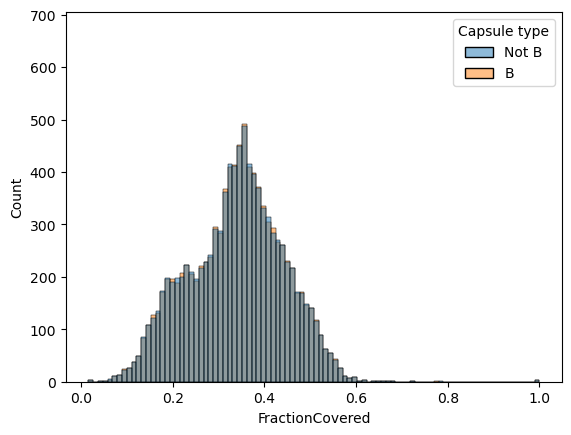

In [28]:
hp_data = balanced_capsule_dataset.copy()
hp_data.Label = hp_data.Label.apply(lambda x: "Not B" if x == 0 else "B")
hp_data = hp_data.rename({"Label": "Capsule type"}, axis=1)
ax = sns.histplot(data=hp_data, x="FractionCovered", hue="Capsule type", hue_order=["Not B", "B"])
ax.set_ylim([0, 705])

We now proceed to split the dataset into training, validation, and test sets. We will use a stratified split by `Label`, assigning a fixed number of genomes for validation (500) and for test (1000).

In [29]:
def split_data(
    genomes_df: pd.DataFrame,
    num_val: int = 500,
    num_test: int = 1000,
) -> pd.DataFrame:
    """Splits data."""
    indices = np.arange(genomes_df.shape[0])
    labels = genomes_df.Label.values
    dev_idx, test_idx = train_test_split(
        indices,
        stratify=labels,
        test_size=num_test,
        random_state=SEED
    )
    train_idx, val_idx = train_test_split(
        dev_idx,
        stratify=labels[dev_idx],
        test_size=num_val,
        random_state=SEED
    )
    genomes_df["Partition"] = None
    genomes_df.loc[train_idx, "Partition"] = "training"  
    genomes_df.loc[val_idx, "Partition"] = "validation"  
    genomes_df.loc[test_idx, "Partition"] = "test"  
    return genomes_df[["Path", "Label", "Partition"]]

capsule_dataset = split_data(balanced_capsule_dataset, num_val=500, num_test=1000)

Here's the final composition of the `capsule` dataset:

In [30]:
def print_dataset_statistics(df):
    print("Total number of genomes:", df.shape[0])
    print()
    
    training_set = df[df.Partition=="training"]
    print("Training set genomes:", training_set.shape[0])
    print(f"Of which {training_set[training_set.Label==0].shape[0]} with label 0 and {training_set[training_set.Label==1].shape[0]} with label 1")
    print()

    validation_set = df[df.Partition=="validation"]
    print("Validation set genomes:", validation_set.shape[0])
    print(f"Of which {validation_set[validation_set.Label==0].shape[0]} with label 0 and {validation_set[validation_set.Label==1].shape[0]} with label 1")
    print()

    test_set = df[df.Partition=="test"]
    print("Test set genomes:", test_set.shape[0])
    print(f"Of which {test_set[test_set.Label==0].shape[0]} with label 0 and {test_set[test_set.Label==1].shape[0]} with label 1")
    print()

print_dataset_statistics(capsule_dataset)



Total number of genomes: 19498

Training set genomes: 17998
Of which 8999 with label 0 and 8999 with label 1

Validation set genomes: 500
Of which 250 with label 0 and 250 with label 1

Test set genomes: 1000
Of which 500 with label 0 and 500 with label 1



## `disease` dataset
For the `disease` dataset, we used a similar workflow. First, we kept genomes where the `disease` column was one of: `carrier`, `invasive (unspecified/other)`, `meningitis`, `septicaemia`, `meningitis and septicaemia`, and discarded the rest, narrowing the set to 25290 genomes.

In [31]:
phenotypes =  ["carrier", "invasive (unspecified/other)", "meningitis", "septicaemia", "meningitis and septicaemia",]
disease_genomes = genomes[genomes.disease.isin(phenotypes)].copy()
print("Total genomes for disease task:", disease_genomes.shape[0])

Total genomes for disease task: 20442


Then, we assign label `0` to genomes with `disease` equal to `carrier`, and label `1` otherwise 

In [32]:
def get_disease_label(disease: str) -> int:
    if disease == "carrier":
        return 0
    return 1

disease_genomes["Label"] = disease_genomes.disease.apply(get_disease_label)

print("Total genomes after filtering:", disease_genomes.shape[0])
print("Distribution of labels:")
disease_genomes.Label.value_counts()

Total genomes after filtering: 20442
Distribution of labels:


1    15196
0     5246
Name: Label, dtype: int64

We can see that the dataset is imbalanced in favor of the `1` class. We again calculate the fraction of genome covered by the 10 longest contigs:

In [33]:
updated_disease_genomes = calculate_fraction_covered(disease_genomes)
format_and_save_dataset(updated_disease_genomes, "fig2_panelC.csv")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1924 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 3024 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 4324 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 7524 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 9424 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 11524 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 13824 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 16324 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 19024 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 20442 out of 20442 | elapsed:   20.8s finished


And, similarly to the `capsule` example, we plot `FractionCovered` stratified by `Label`, revealing the bias in this case too:

(0.0, 705.0)

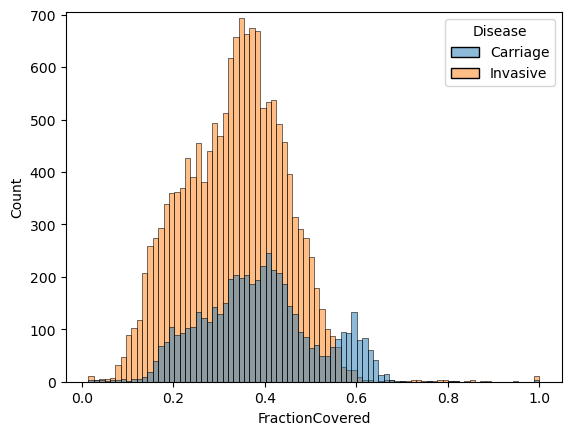

In [34]:
hp_data = updated_disease_genomes.copy()
hp_data.Label = hp_data.Label.apply(lambda x: "Carriage" if x == 0 else "Invasive")
hp_data = hp_data.rename({"Label": "Disease"}, axis=1)
ax = sns.histplot(data=hp_data, x="FractionCovered", hue="Disease", hue_order=["Carriage", "Invasive"])
ax.set_ylim([0, 705])

We proceed to remove the bias in the same way as we did for the `capsule` task.

In [35]:
balanced_disease_dataset = balance_quality(updated_disease_genomes)
format_and_save_dataset(balanced_disease_dataset, "fig2_panelD.csv")

/home/mp894858/miniconda3/envs/genpred/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


We plot again the histogram of `FractionCovered` stratified by `Label`, to see that the bias issue has been resolved.

(0.0, 705.0)

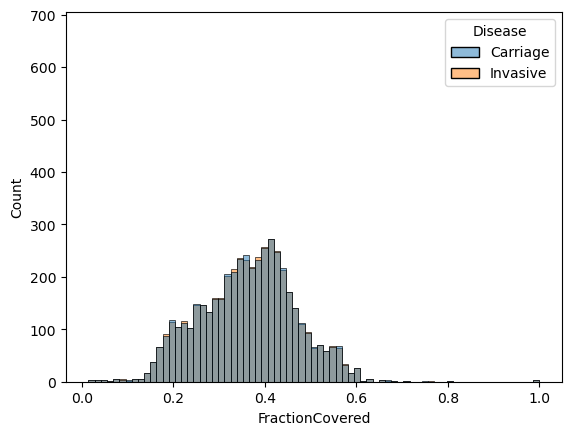

In [36]:
hp_data = balanced_disease_dataset.copy()
hp_data.Label = hp_data.Label.apply(lambda x: "Carriage" if x == 0 else "Invasive")
hp_data = hp_data.rename({"Label": "Disease"}, axis=1)
ax = sns.histplot(data=hp_data, x="FractionCovered", hue="Disease", hue_order=["Carriage", "Invasive"])
ax.set_ylim([0, 705])

We split the data reserving 500 genomes for validation and 1000 genomes for test as we did before.

In [37]:
disease_dataset = split_data(balanced_disease_dataset, num_val=500, num_test=1000)

Here's the final composition of the `disease` dataset.

In [38]:
print_dataset_statistics(disease_dataset)


Total number of genomes: 9402

Training set genomes: 7902
Of which 3951 with label 0 and 3951 with label 1

Validation set genomes: 500
Of which 250 with label 0 and 250 with label 1

Test set genomes: 1000
Of which 500 with label 0 and 500 with label 1

